In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D 
import numpy as np
import scipy as sp
import pandas as pd
from scipy.interpolate import pchip_interpolate as interp
from scipy.interpolate import pchip

import pickle

# Fused wrapped Fortran wake models
from FortranWake.fused_fortran import FNOJ, FGCL, AEP_f
from FortranWake.fusedwasp import PlantFromWWH, WTDescFromWTG

# FusedWind
from fusedwind.plant_flow.vt import GenericWindFarmTurbineLayout, WTPC, WeibullWindRoseVT, GenericWindRoseVT

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
wt_layout = PlantFromWWH('hornsrev1_turbine_nodescription.wwh').wt_layout
P_rated = np.sum(wt_layout.wt_array('power_rating'))

1


In [3]:
for wt in wt_layout.wt_list:
    PCI = pchip(np.append(3.,wt.power_curve[:,0]),np.append(0.,wt.power_curve[:,1]))
    CTCI = pchip(np.append(3.,wt.c_t_curve[:,0]),np.append(0.053,wt.c_t_curve[:,1]))
    wt.cut_in_wind_speed = 3.
    u_c = np.linspace(3.,wt.cut_out_wind_speed,211,endpoint=True)
    p_c = PCI(u_c)
    ct_c = CTCI(u_c)
    wt.power_curve = np.vstack([u_c,p_c]).T
    wt.c_t_curve = np.vstack([u_c,ct_c]).T
    wt.c_t_idle = 0.053
    if wt.name[-2]=='_':
        wt.name='wt_0'+wt.name[-1]

In [4]:
df = pd.DataFrame([wt_layout.create_dict(n) for n in range(wt_layout.n_wt)])

In [5]:
def circles(x, y, s, c='b', ax=None, vmin=None, vmax=None, **kwargs):
    """
    Make a scatter of circles plot of x vs y, where x and y are sequence 
    like objects of the same lengths. The size of circles are in data scale.

    Parameters
    ----------
    x,y : scalar or array_like, shape (n, )
        Input data
    s : scalar or array_like, shape (n, ) 
        Radius of circle in data scale (ie. in data unit)
    c : color or sequence of color, optional, default : 'b'
        `c` can be a single color format string, or a sequence of color
        specifications of length `N`, or a sequence of `N` numbers to be
        mapped to colors using the `cmap` and `norm` specified via kwargs.
        Note that `c` should not be a single numeric RGB or
        RGBA sequence because that is indistinguishable from an array of
        values to be colormapped.  `c` can be a 2-D array in which the
        rows are RGB or RGBA, however.
    ax : Axes object, optional, default: None
        Parent axes of the plot. It uses gca() if not specified.
    vmin, vmax : scalar, optional, default: None
        `vmin` and `vmax` are used in conjunction with `norm` to normalize
        luminance data.  If either are `None`, the min and max of the
        color array is used.  (Note if you pass a `norm` instance, your
        settings for `vmin` and `vmax` will be ignored.)

    Returns
    -------
    paths : `~matplotlib.collections.PathCollection`

    Other parameters
    ----------------
    kwargs : `~matplotlib.collections.Collection` properties
        eg. alpha, edgecolors, facecolors, linewidths, linestyles, norm, cmap

    Examples
    --------
    a = np.arange(11)
    circles(a, a, a*0.2, c=a, alpha=0.5, edgecolor='none')

    License
    --------
    This code is under [The BSD 3-Clause License]
    (http://opensource.org/licenses/BSD-3-Clause)
    """
    from matplotlib.patches import Circle
    from matplotlib.collections import PatchCollection
    import pylab as plt
    #import matplotlib.colors as colors

    if ax is None:
        ax = plt.gca()    

    if isinstance(c,basestring):
        color = c     # ie. use colors.colorConverter.to_rgba_array(c)
    else:
        color = None  # use cmap, norm after collection is created
    kwargs.update(color=color)

    if np.isscalar(x):
        patches = [Circle((x, y), s),]
    elif np.isscalar(s):
        patches = [Circle((x_,y_), s) for x_,y_ in zip(x,y)]
    else:
        patches = [Circle((x_,y_), s_) for x_,y_,s_ in zip(x,y,s)]
    collection = PatchCollection(patches, **kwargs)

    if color is None:
        collection.set_array(np.asarray(c))
        if vmin is not None or vmax is not None:
            collection.set_clim(vmin, vmax)

    ax.add_collection(collection)
    ax.autoscale_view()
    return collection

(423000.0, 430000.0, 6146000.0, 6153000.0)

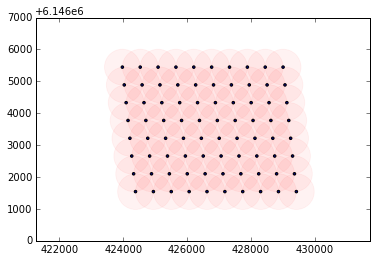

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
circles(df.x, df.y, s=7.*df.rotor_diameter, c='r', alpha=0.05,edgecolors='none',ax=ax)
circles(df.x, df.y, s=df.rotor_diameter/2., c=df.power_rating,edgecolors='none',ax=ax)
ax.axis('equal')

### Single flow NOJ

In [18]:
NOJ_s = FNOJ()
NOJ_s.wind_speeds=np.array(10.)
NOJ_s.wind_directions= np.array(270.0)
NOJ_s.wake_expansions= np.array(0.05)
NOJ_s.wt_layout = wt_layout
NOJ_s.run()
NOJ_s.power/1e6

array([ 53.4871766])

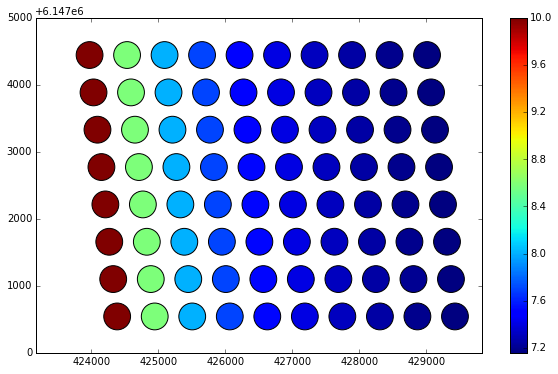

In [19]:
fig=plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
co=circles(df.x, df.y, s=5*df.rotor_diameter/2., c=NOJ_s.wt_wind_speed[0,:],edgecolors='none',ax=ax)
ax.axis('equal')
fig.colorbar(co)
print

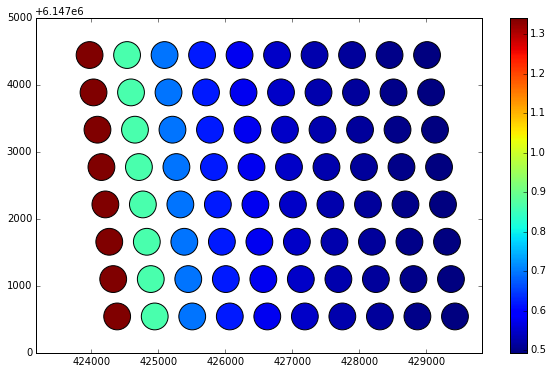

In [20]:
fig=plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
co=circles(df.x, df.y, s=5*df.rotor_diameter/2., c=NOJ_s.wt_power[0]/1e6,edgecolors='none',ax=ax)
ax.axis('equal')
fig.colorbar(co)
print

### Single Flow GCL

In [21]:
GCL_s = FGCL()
GCL_s.wind_speeds=np.array(4.2)
GCL_s.wind_directions=np.array(270.)
GCL_s.turbulence_intensities=np.array(0.07)
GCL_s.wt_layout = wt_layout
GCL_s.run()
GCL_s.power/1e6

array([ 1.58543136])

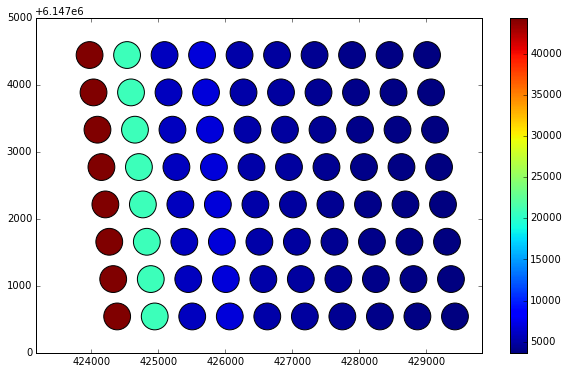

In [22]:
fig=plt.figure(figsize=[10,6])
ax = fig.add_subplot(111)
co = circles(df.x, df.y, s=5*df.rotor_diameter/2., c=GCL_s.wt_wind_speed[0,:], edgecolors='none',ax=ax)
ax.axis('equal')
fig.colorbar(co)
print

###Multiple flow NOJ

In [27]:
wind_speeds = 8.5 #[i for i in np.linspace(4.0,25.,num=43,endpoint=True)]
wind_directions = [i for i in np.linspace(0.,360.,num=360,endpoint=False)]

In [28]:
WS,WD = np.meshgrid(np.array(wind_speeds),np.array(wind_directions))
WS,WD = WS.flatten(),WD.flatten()

In [30]:
NOJ = FNOJ()
NOJ.wind_speeds=WS
NOJ.wind_directions=WD
NOJ.wt_layout = wt_layout
NOJ.wake_expansions=0.040*np.zeros_like(WS)
NOJ.run()
#NOJ.power/1e6 #Power[iWD,iWD]

In [34]:
df_NOJ = pd.DataFrame(data=np.vstack([WS.flatten(),
                                      WD.flatten(),
                                      NOJ.power,
                                      NOJ.wt_power.T,
                                      NOJ.wt_thrust.T,
                                      NOJ.wt_wind_speed.T]).T, 
                      columns=['WS','WD','P_WF']+['P_'+name[-2:] for name in wt_layout.wt_array(attr='name')]\
                             +['T_'+name[-2:] for name in wt_layout.wt_array(attr='name')]\
                             +['U_'+name[-2:] for name in wt_layout.wt_array(attr='name')]) 
df_NOJ.to_csv('df_NOJ_kj_0p04.csv')
df_NOJ.head()

,WS,WD,P_WF,P_81,P_54,P_42,P_48,P_98,P_61,P_62,...,U_37,U_36,U_35,U_34,U_55,U_74,U_88,U_32,U_57,U_65
0,8.5,0,51617703.676710,838983.964846,627147.629686,597382.480978,618503.517096,627478.296239,838983.964846,597382.480978,...,7.694167,7.733463,7.698041,7.696974,7.694264,7.693243,7.694125,7.612343,7.697897,7.698437
1,8.5,1,56643969.880002,838983.964846,705612.140919,688799.564723,633676.058485,705668.400987,838983.964846,688799.564723,...,8.002219,8.035544,8.004220,8.004121,8.002189,8.002097,7.700188,7.972393,8.004242,8.004349
2,8.5,2,57257602.343898,838983.964846,780108.263442,770875.561493,192597.084764,780108.152335,838983.964846,770875.561493,...,8.248140,8.301155,8.276604,8.276625,8.275874,8.275895,5.327461,8.270190,8.248870,8.276625
3,8.5,3,56379691.983909,838983.964846,834387.986673,830640.598972,199536.879811,834387.502989,838983.964846,830640.598972,...,6.289655,8.484284,8.472636,8.472639,8.472587,8.472589,5.427807,8.472526,6.289705,8.472636
4,8.5,4,55159204.109791,838983.964846,838983.964846,838983.964846,247349.144692,838983.964846,838983.964846,838983.964846,...,5.762205,7.977395,8.500000,8.500000,8.500000,8.500000,5.771511,8.500000,5.762205,8.500000


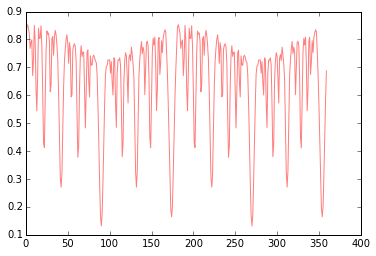

In [59]:
plt.plot(df_NOJ.WD,df_NOJ.P_WF/(80.*PCI(df_NOJ.WS)),'-r',alpha=0.5)

###Multiple flow GCL

In [42]:
wind_speeds = 8.5 #[i for i in np.linspace(4.0,25.,num=43,endpoint=True)]
wind_directions = [i for i in np.linspace(0.,360.,num=360,endpoint=False)]
tis = 0.08#[i for i in np.logspace(np.log10(0.04),np.log10(0.20),num=3,endpoint=True)]

In [43]:
WS,WD = np.meshgrid(np.array(wind_speeds),np.array(wind_directions))
WS,TI = np.meshgrid(WS.flatten(),np.array(tis))
WD,__ = np.meshgrid(WD.flatten(),np.array(tis))
WS,WD,TI = WS.flatten(),WD.flatten(),TI.flatten()

In [45]:
GCL = FGCL()
GCL.wind_speeds=WS
GCL.wind_directions=WD
GCL.turbulence_intensities=TI
GCL.wt_layout = wt_layout
GCL.run()
#GCL.power/1e6 #Power[iWD,iWD]

In [46]:
df_GCL = pd.DataFrame(data=np.vstack([WS.flatten(),
                                      WD.flatten(),
                                      TI.flatten(),
                                      NOJ.power,
                                      NOJ.wt_power.T,
                                      NOJ.wt_thrust.T,
                                      NOJ.wt_wind_speed.T]).T, 
                      columns=['WS','WD','TI','P_WF']+['P_'+name[-2:] for name in wt_layout.wt_array(attr='name')]\
                             +['T_'+name[-2:] for name in wt_layout.wt_array(attr='name')]\
                             +['U_'+name[-2:] for name in wt_layout.wt_array(attr='name')]) 
df_GCL.to_csv('df_GCL.csv')
df_GCL.head()

,WS,WD,TI,P_WF,P_81,P_54,P_42,P_48,P_98,P_61,...,U_37,U_36,U_35,U_34,U_55,U_74,U_88,U_32,U_57,U_65
0,8.5,0,0.08,51617703.676710,838983.964846,627147.629686,597382.480978,618503.517096,627478.296239,838983.964846,...,7.694167,7.733463,7.698041,7.696974,7.694264,7.693243,7.694125,7.612343,7.697897,7.698437
1,8.5,1,0.08,56643969.880002,838983.964846,705612.140919,688799.564723,633676.058485,705668.400987,838983.964846,...,8.002219,8.035544,8.004220,8.004121,8.002189,8.002097,7.700188,7.972393,8.004242,8.004349
2,8.5,2,0.08,57257602.343898,838983.964846,780108.263442,770875.561493,192597.084764,780108.152335,838983.964846,...,8.248140,8.301155,8.276604,8.276625,8.275874,8.275895,5.327461,8.270190,8.248870,8.276625
3,8.5,3,0.08,56379691.983909,838983.964846,834387.986673,830640.598972,199536.879811,834387.502989,838983.964846,...,6.289655,8.484284,8.472636,8.472639,8.472587,8.472589,5.427807,8.472526,6.289705,8.472636
4,8.5,4,0.08,55159204.109791,838983.964846,838983.964846,838983.964846,247349.144692,838983.964846,838983.964846,...,5.762205,7.977395,8.500000,8.500000,8.500000,8.500000,5.771511,8.500000,5.762205,8.500000


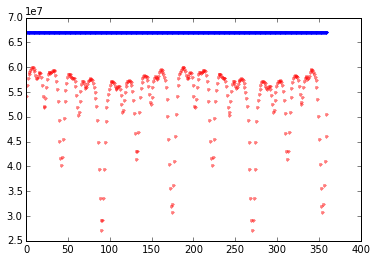

In [51]:
plt.plot(WD,GCL.power,'.r',alpha=0.5)
plt.plot(WD,80.*PCI(WS),'.')

## AEP with fortran fused wake models

In [12]:
# The wind rose
weibull_array = np.array([[  0.00000000e+00,   3.59673400e-02,  9.22422800e+00,   2.38867200e+00],
                         [  3.00000000e+01,   3.94977300e-02,   9.86435600e+00,   2.44726600e+00],
                         [  6.00000000e+01,   5.17838000e-02,   9.65220200e+00,   2.41992200e+00],
                         [  9.00000000e+01,   6.99794900e-02,   9.98217800e+00,   2.58789100e+00],
                         [  1.20000000e+02,   8.36383000e-02,   1.00946000e+01,   2.74804700e+00],
                         [  1.50000000e+02,   6.43412500e-02,   9.64369000e+00,   2.59179700e+00],
                         [  1.80000000e+02,   8.64220000e-02,   9.63377500e+00,   2.58007800e+00],
                         [  2.10000000e+02,   1.17690000e-01,   1.05678600e+01,   2.54492200e+00],
                         [  2.40000000e+02,   1.51555100e-01,   1.14525200e+01,   2.46679700e+00],
                         [  2.70000000e+02,   1.47361100e-01,   1.17423700e+01,   2.60351600e+00],
                         [  3.00000000e+02,   1.00109800e-01,   1.16923200e+01,   2.62304700e+00],
                         [  3.30000000e+02,   5.16542400e-02,   1.01385800e+01,   2.32226600e+00]])
wind_rose = WeibullWindRoseVT()
wind_rose.wind_directions = weibull_array[:,0]
wind_rose.frequency = weibull_array[:,1]
wind_rose.k = weibull_array[:,3]
wind_rose.A = weibull_array[:,2]

In [13]:
wind_speeds = [i for i in np.linspace(4.0,25.,num=43,endpoint=True)]
wind_directions = [i for i in np.linspace(0.,360.,num=720,endpoint=False)]

In [17]:
aep = AEP_f(wt_layout=wt_layout,
          wind_rose=wind_rose,
          wf=FNOJ(),
          wind_speeds=wind_speeds,
          wind_directions=wind_directions,
          scaling=1.0,
          wt_positions=wt_layout.wt_array(attr='position'))
aep.wf.wake_expansions = 0.05*np.zeros_like(aep.wf.wind_speeds)
aep.run()

print aep.net_aep/1e12
print aep.gross_aep/1e12
print aep.capacity_factor

AttributeError: 'AEP_f' object has no attribute '_parent'

In [14]:
aep = AEP_f(wt_layout=wt_layout,
          wind_rose=wind_rose,
          wf=FGCL(),
          wind_speeds=wind_speeds,
          wind_directions=wind_directions,
          scaling=1.0,
          wt_positions=wt_layout.wt_array(attr='position'))
aep.wf.NG = 4
aep.wf.TI = 0.08

aep.run()
print aep.net_aep/1e12
print aep.gross_aep/1e12
print aep.capacity_factor

1.0
0.659115576439
0.747460127199
0.881807005423
